# structflo-cser — Quickstart

This notebook walks through the **Chemical Structure + Label Extraction** pipeline
step-by-step, then shows the one-liner convenience API.

**Pipeline stages:**
1. **Detect** — YOLO finds chemical structures and compound labels
2. **Match** — Hungarian algorithm pairs each structure with its nearest label
3. **Extract** — DECIMER converts structure crops → SMILES; EasyOCR reads label text



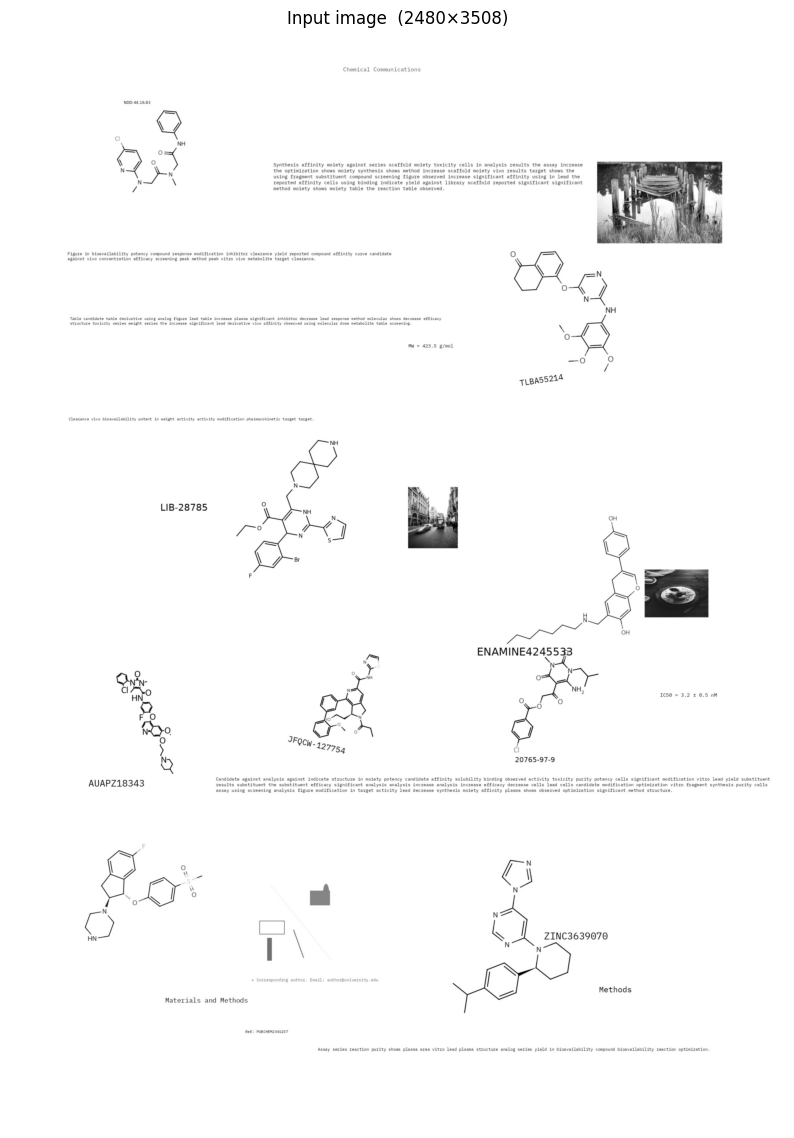

In [182]:
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

from structflo.cser.viz import plot_detections, plot_pairs, plot_crops, plot_results

# Choose a test image (change the filename as needed)
IMAGE_PATH = Path("../data/test_images/val_000193.jpg")
assert IMAGE_PATH.exists(), f"Image not found: {IMAGE_PATH}"

img = Image.open(IMAGE_PATH).convert("RGB")
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.axis("off")
plt.title(f"Input image  ({img.width}×{img.height})")
plt.show()

## Part 1 — Step-by-step pipeline

### 1a. Create the pipeline

The pipeline is lazy — YOLO weights, DECIMER, and EasyOCR are only loaded on first use.

In [183]:
from structflo.cser.pipeline import ChemPipeline
from structflo.cser.lps import LearnedMatcher

# Create pipeline — no tiling for this small demo image, match within 500px
pipeline = ChemPipeline(
    weights="../runs/labels_detect/yolo11l_panels/weights/last.pt",
    tile=False,
    conf=0.60,
    matcher=LearnedMatcher(
        weights="../runs/lps/scorer_best.pt"
        ),
    )
print("Pipeline created (models not loaded yet)")

Pipeline created (models not loaded yet)


### 1b. Detect — find structures and labels

`pipeline.detect()` runs YOLO and returns a flat list of `Detection` objects (class 0 = structure, class 1 = label).

In [184]:
detections = pipeline.detect(IMAGE_PATH)

n_struct = sum(1 for d in detections if d.class_id == 0)
n_label  = sum(1 for d in detections if d.class_id == 1)
print(f"Found {n_struct} structures and {n_label} labels  ({len(detections)} total detections)")

Found 9 structures and 8 labels  (17 total detections)


### Visualise detections

Green = chemical structure, Blue = compound label.

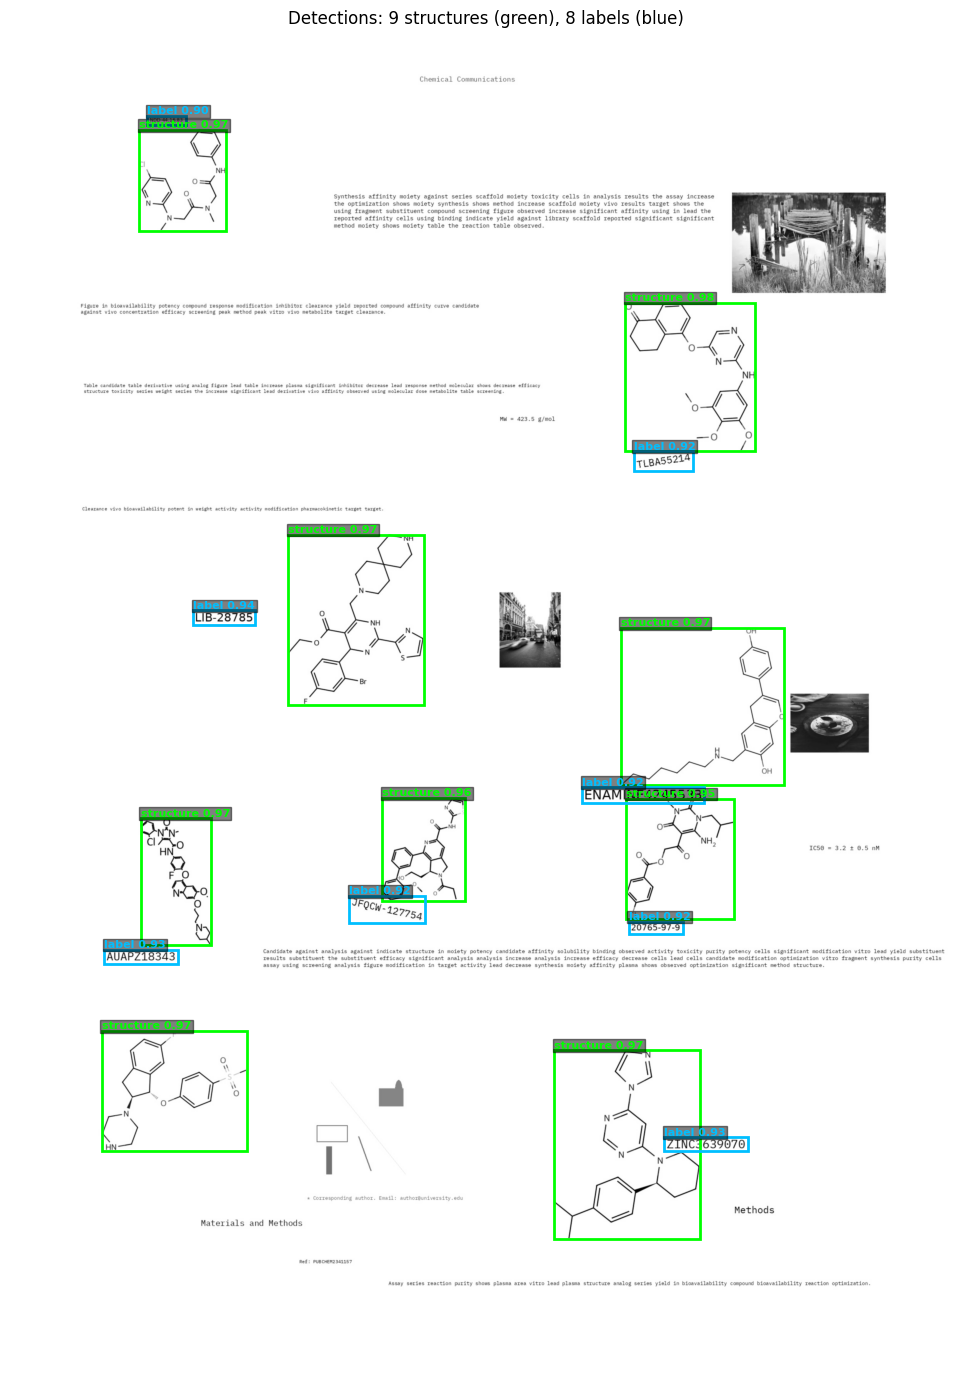

In [185]:
fig = plot_detections(img, detections)
plt.show()

### 1c. Match — pair structures with labels

`pipeline.match()` uses the Hungarian algorithm to optimally pair each structure with its nearest label by centroid distance.

In [186]:
pairs = pipeline.match(detections, image=img)
print(f"Matched {len(pairs)} structure–label pairs\n")

for i, p in enumerate(pairs):
    sc = p.structure.bbox.centroid
    lc = p.label.bbox.centroid
    print(f"  Pair {i}: distance={p.match_distance:.0f}px  "
          f"structure@({sc[0]:.0f},{sc[1]:.0f})  label@({lc[0]:.0f},{lc[1]:.0f})")

Matched 4 structure–label pairs

  Pair 0: distance=0px  structure@(1606,2895)  label@(1811,2894)
  Pair 1: distance=0px  structure@(900,1528)  label@(557,1523)
  Pair 2: distance=0px  structure@(449,385)  label@(407,229)
  Pair 3: distance=0px  structure@(1802,1754)  label@(1648,1985)


### Visualise matched pairs

Orange lines connect each structure to its matched label.

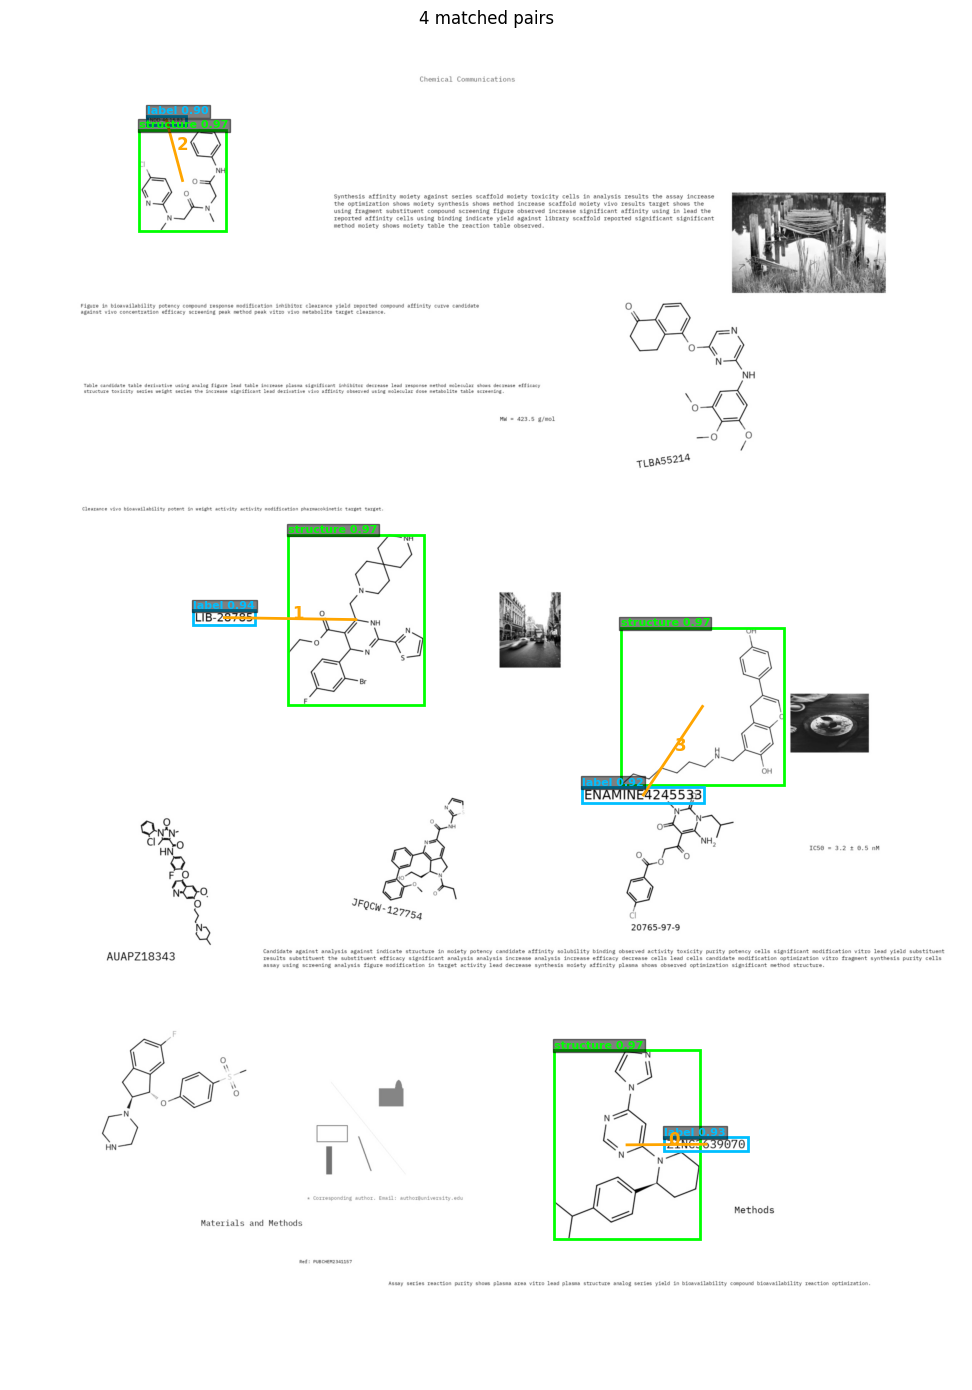

In [187]:
fig = plot_pairs(img, pairs)
plt.show()

### 1d. Show cropped regions for each pair

For each matched pair, we crop the structure and label regions from the original image.

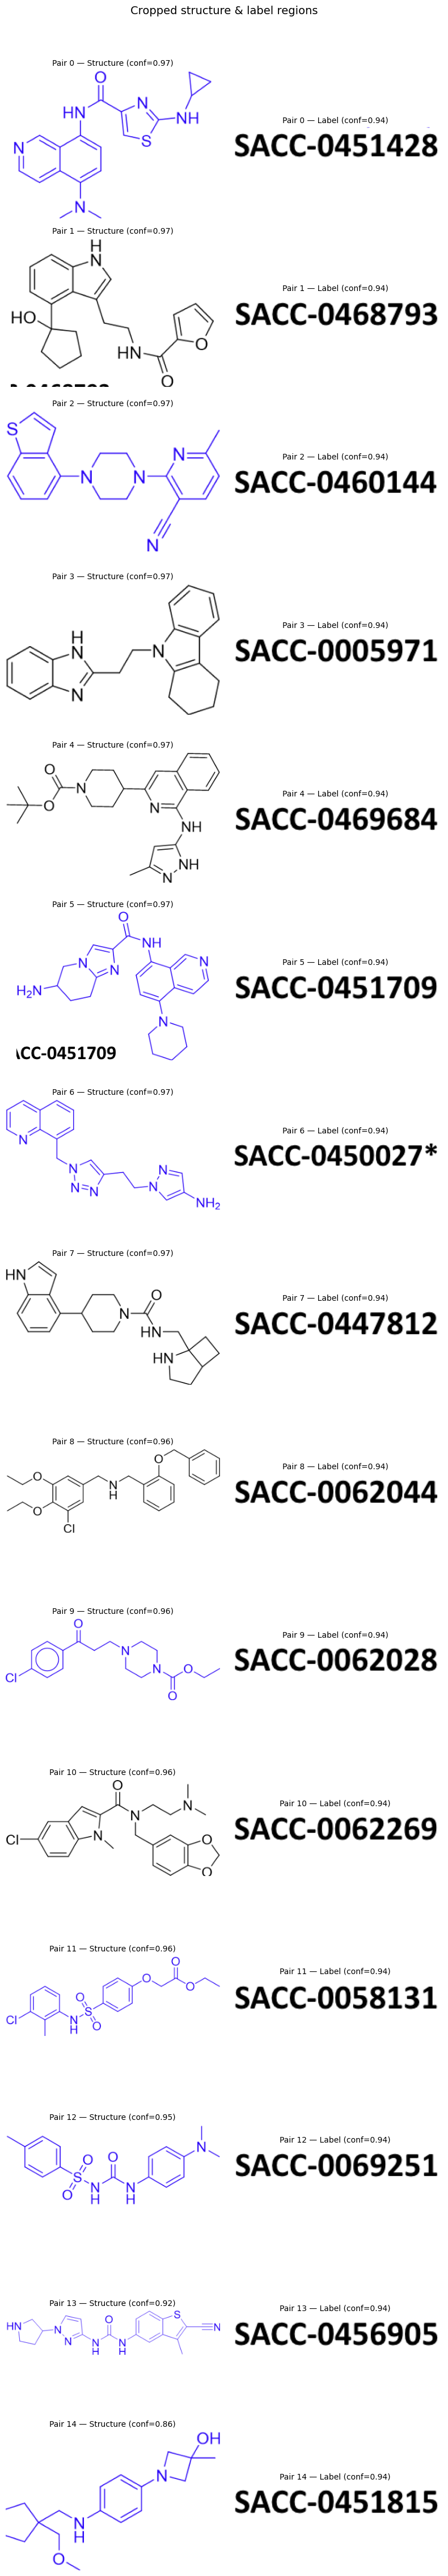

In [181]:
fig = plot_crops(img, pairs)
plt.show()

### 1e. Extract — SMILES and label text

`pipeline.enrich()` runs DECIMER on each structure crop and EasyOCR on each label crop, populating `pair.smiles` and `pair.label_text`.

In [ ]:
enriched_pairs = pipeline.enrich(pairs, IMAGE_PATH)

for i, p in enumerate(enriched_pairs):
    print(f"Pair {i}:")
    print(f"  SMILES:     {p.smiles}")
    print(f"  Label text: {p.label_text}")
    print(f"  Distance:   {p.match_distance:.0f}px")
    print()

### 1f. Results as a DataFrame

In [ ]:
df = ChemPipeline.to_dataframe(enriched_pairs)
df

---

## Part 2 — Full pipeline in one call

Everything above (detect → match → enrich) can be done in a single `process()` call.

In [ ]:
from structflo.cser.pipeline import ChemPipeline, HungarianMatcher

# Create pipeline
pipeline = ChemPipeline(
    tile=False,
    conf=0.70,
    matcher=HungarianMatcher(max_distance=500),
)
print("Pipeline created (models not loaded yet)")

In [ ]:
# One-liner: detect + match + extract SMILES & OCR in a single call
results = pipeline.process(IMAGE_PATH)

# View as DataFrame
ChemPipeline.to_dataframe(results)

In [ ]:
fig = plot_results(img, results)
plt.show()

### Export to JSON

In [ ]:
print(ChemPipeline.to_json(results))

### Final annotated image with extracted info

In [ ]:
fig = plot_results(img, results)
plt.show()